In [1]:
import json
import numpy as np
import pandas as pd
import shapely.wkt
import shapely.ops
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
links_df = pd.read_csv('../network_inputs/osm_edges.csv')
links_gdf = gpd.GeoDataFrame(links_df, crs=4326, geometry=links_df['geometry'].map(shapely.wkt.loads))
roads_gdf = links_gdf.copy()
links_gdf = links_gdf.to_crs(26910)
links_gdf['start_lon_proj'] = links_gdf['geometry'].apply(lambda x: x.coords[0][0])
links_gdf['start_lat_proj'] = links_gdf['geometry'].apply(lambda x: x.coords[0][1])
links_gdf['end_lon_proj'] = links_gdf['geometry'].apply(lambda x: x.coords[-1][0])
links_gdf['end_lat_proj'] = links_gdf['geometry'].apply(lambda x: x.coords[-1][1])
# links_df

[<matplotlib.lines.Line2D object at 0x7fad1b790ad0>, <matplotlib.lines.Line2D object at 0x7fad1b60acd0>, <matplotlib.lines.Line2D object at 0x7fad1b6118d0>, <matplotlib.lines.Line2D object at 0x7fad1b663f10>, <matplotlib.lines.Line2D object at 0x7fad1b651350>, <matplotlib.lines.Line2D object at 0x7fad1b6309d0>, <matplotlib.lines.Line2D object at 0x7fad1b5c3050>, <matplotlib.lines.Line2D object at 0x7fad1b5c3bd0>, <matplotlib.lines.Line2D object at 0x7fad1b5c9110>]


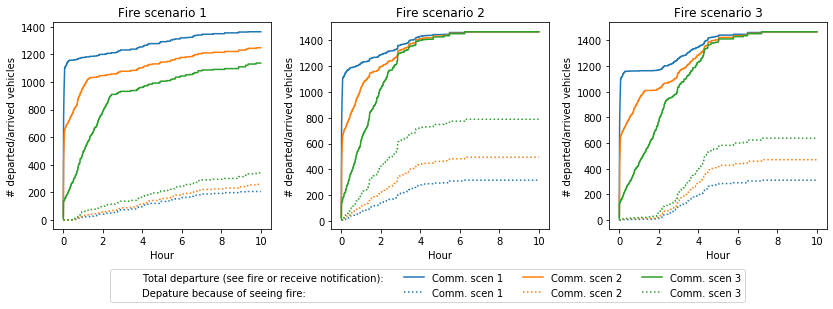

In [20]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
fig.tight_layout(pad=3)

rs = 0
vphh = 2
vist = 300
color = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
p_solid, p_dash = [], []
for commscen in [0, 1, 2]:
    c = next(color)
    for firescen in [1, 2, 3]:
        t_stats = pd.read_csv('t_stats/t_stats_scenrs{}_f{}_c{}_vphh{}_vist{}_nodetour.csv'.format(rs, firescen, commscen, vphh, vist))
        p_solid_i, = ax[firescen-1].plot(t_stats['t']/3600, 1490-t_stats['predepart'], c=c)
        p_dash_i, = ax[firescen-1].plot(t_stats['t']/3600, t_stats['see_fire'], c=c, ls=':')
        # ax[firescen-1].plot(t_stats['t']/3600, t_stats['arr'], c=c, ls=':')
        ax[firescen-1].set_xlabel('Hour')
        ax[firescen-1].set_ylabel('# departed/arrived vehicles')
        ax[firescen-1].set_title('Fire scenario {}'.format(firescen))

        p_solid.append(p_solid_i)
        p_dash.append(p_dash_i)
        p5, = plt.plot([0], marker='None', linestyle='None', label='dummy-tophead')
        p7, = plt.plot([0],  marker='None', linestyle='None', label='dummy-empty')
plt.legend([p5, p7, p_solid[0], p_dash[0], p_solid[3], p_dash[3], p_solid[6], p_dash[6]], ['Total departure (see fire or receive notification):', 'Depature because of seeing fire:', 'Comm. scen 1', 'Comm. scen 1', 'Comm. scen 2', 'Comm. scen 2', 'Comm. scen 3', 'Comm. scen 3'], loc=[-2.3,-0.35], ncol=4)
print(p_solid)

In [ ]:
def add_geom(rs=None, firescen=None, commscen=None, vphh=None, vist=None, t=None):
    link_stats = pd.read_csv('link_stats/link_stats_rs{}_f{}_c{}_vphh{}_vist{}_t{}.csv'.format(rs, firescen, commscen, vphh, vist, t))
    link_stats = pd.merge(link_stats, links_df[['edge_id_igraph', 'geometry']], how='left', left_on='link_id', right_on='edge_id_igraph')
#     print(link_stats[link_stats['q']>0].shape)
    link_stats.to_csv('../visualization_outputs/link_stats/link_stats_rs{}_f{}_c{}_vphh{}_vist{}_t{}.csv'.format(rs, firescen, commscen, vphh, vist, t))

for t in range(6000, 18000, 1200):
    add_geom(rs=0, firescen=3, commscen=0, vphh=2, vist=300, t=t)
    add_geom(rs=0, firescen=3, commscen=2, vphh=2, vist=300, t=t)

In [ ]:
from shapely.geometry import Point

closed_links = []
def get_road_closure(firescen=1):
    ### flame length
    flame_length = pd.read_csv(open('../demand_inputs/flame_length/point_firescen{}.csv'.format(firescen)))
    flame_length = gpd.GeoDataFrame(flame_length, crs='epsg:4326', geometry=[Point(xy) for xy in zip(flame_length.lon, flame_length.lat)]).to_crs('epsg:26910')
    flame_length['lon'], flame_length['lat'] = flame_length['geometry'].x, flame_length['geometry'].y
    
    for hour in range(1, 11):
        flame_length_hour = flame_length.loc[(flame_length['t_hour']==hour) & (flame_length['flame_length']>2)]
        print('fire {}, hour {}, flame point cnts {}'.format(firescen, hour, flame_length_hour.shape))
        if flame_length_hour.shape[0]==0:
            continue

        for link in links_gdf.itertuples():
            end_lon_proj, start_lon_proj, end_lat_proj, start_lat_proj = getattr(link, 'end_lon_proj'), getattr(link, 'start_lon_proj'), getattr(link, 'end_lat_proj'), getattr(link, 'start_lat_proj')
            l13 = np.vstack((flame_length_hour['lon'] - start_lon_proj, flame_length_hour['lat'] - start_lat_proj)).T
            l23 = np.vstack((flame_length_hour['lon'] - end_lon_proj, flame_length_hour['lat'] - end_lat_proj)).T
            l12 = (end_lon_proj - start_lon_proj, end_lat_proj - start_lat_proj)
            l21 = (start_lon_proj - end_lon_proj, start_lat_proj - end_lat_proj)
            ### line distance
            line_dist = np.abs(np.matmul(l13, (l12[-1], -l12[0]))) / np.linalg.norm(l12)
            ### start_dist_array
            start_node_distance = np.linalg.norm(l13, axis=1)
            start_node_angle = np.matmul(l13, l12)
            ### end_dist_array
            end_node_distance = np.linalg.norm(l23, axis=1)
            end_node_angle = np.matmul(l23, l21)
            point_line_dist = np.where(start_node_angle<0, start_node_distance,
                                        np.where(end_node_angle<0, end_node_distance, line_dist))
            if np.min(point_line_dist) < 20: ### within 20=(1.414*30/2) m of the cell centroid. Cell width ~= 30m
                closure_status = 'closed'
                closed_links.append([firescen, hour, getattr(link, 'edge_id_igraph')])

firescen=3
get_road_closure(firescen)
closed_links_df = pd.DataFrame(closed_links, columns=['firescen', 'hour', 'link_id'])
closed_links_df.to_csv('../demand_inputs/closed_links/closed_links_firescen{}.csv'.format(firescen), index=False)
closed_links_df.head()

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,15))

t=1200
rs, firescen, vphh, vist = 0, 3, 2, 300
for commscen in [0, 1, 2]:
    link_stats = pd.read_csv('link_stats/link_stats_rs{}_f{}_c{}_vphh{}_vist{}_t{}.csv'.format(rs, firescen, commscen, vphh, vist, t))
    print(link_stats[link_stats['q']>0].shape, np.sum(link_stats['q']))
    link_stats = pd.merge(roads_gdf[['edge_id_igraph', 'length', 'geometry']], link_stats, how='inner', right_on='link_id', left_on='edge_id_igraph')
    closed_links = pd.read_csv('../demand_inputs/closed_links/closed_links_firescen{}.csv'.format(firescen))
    closed_links = closed_links[closed_links['hour']==(t//3600)]
    closed_links = pd.merge(roads_gdf[['edge_id_igraph', 'geometry']], closed_links, how='inner', right_on='link_id', left_on='edge_id_igraph')

    roads_plot = roads_gdf.to_crs(26910).plot(ax=ax[commscen], lw=0.5, color='gray')
    closed_plot = closed_links.to_crs(26910).plot(ax=ax[commscen], lw=5, color='red', alpha=0.5)
#     runs_geom = link_stats.copy()
#     runs_geom['geometry'] = runs_geom[runs_geom['r']>0].to_crs(26910).apply(lambda x: x['geometry'].interpolate(x['r']*8/x['length'], normalized=True), axis=1)
#     runs_plot = runs_geom.plot(ax=ax[commscen], color='green')

    queues_geom = link_stats.copy()
    # queues_geom['geometry'] = queues_geom[queues_geom['q']>1].to_crs(26910).apply(lambda x: shapely.ops.substring( x['geometry'], 1-x['r']*8/x['length'], 1, normalized=True), axis=1)
    # queues_plot = queues_geom.plot(ax=ax[commscen], lw=1, color='purple')
    queues_plot = queues_geom[queues_geom['q']>1].to_crs(26910).plot(ax=ax[commscen], lw=1, color='purple')
    # print(link_stats.head())
    # print(queues_geom.head())
    # break
    
    ax[commscen].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    ax[commscen].set_xlim([525000, 528500])
    ax[commscen].set_ylim([4194000, 4199230])
plt.show()

In [ ]:
link_id = '564'
unique_veh_c0 = set()
unique_veh_c2 = set()
for t in range(12001, 12699):
    link_detail_c0 = json.load(open('link_detailed_outputs/link_detail_rs0_f3_c0_vphh2_vist300_t{}.json'.format(t)))
    unique_veh_c0.update([v[0] for v in link_detail_c0[link_id]['run']])
    if 1366 in unique_veh_c0: 
        print(t)
        break
    link_detail_c2 = json.load(open('link_detailed_outputs/link_detail_rs0_f3_c2_vphh2_vist300_t{}.json'.format(t)))
    unique_veh_c2.update([v[0] for v in link_detail_c2[link_id]['run']])
print(len(unique_veh_c0), len(unique_veh_c2))
print(unique_veh_c0)
print(unique_veh_c2)


In [ ]:
link_detail_c0 = json.load(open('link_detailed_outputs/link_detail_rs0_f3_c0_vphh2_vist300_t12039.json'.format(t)))
link_detail_c0['564']

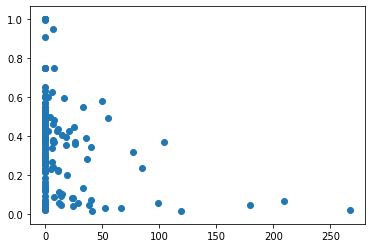

node_id  empty  efficiency  left_turn  efficiency_per_move
506      253     23       17.73        119             0.015051
508      254     24       18.61         41             0.015811
274      137    307       19.58          0             0.021902
212      106     26       26.38        267             0.022451
270      135    145       24.62          0             0.023314
     link_id  efficiency  empty  efficiency_per_move
319      319        26.0    732             0.055437
191      191         1.0   1183             0.055556
194      194        25.0    836             0.068493
281      281        75.0    242             0.078206
118      118        64.0    393             0.079208
..       ...         ...    ...                  ...
101      101         2.0   1199             1.000000
551      551       250.0    951             1.000000
550      550        11.0   1190             1.000000
578      578       267.0    934             1.000000
524      524         2.0   1199       

In [67]:
nodes_df = pd.read_csv('../network_inputs/osm_nodes.csv')
links_df = pd.read_csv('../network_inputs/osm_edges.csv')

t = 1200
node_stats = pd.read_csv('node_stats/node_stats_rs{}_f{}_c{}_vphh{}_vist{}_efficiency_t{}.csv'.format(0, 3, 0, 2, 300, t))
node_stats = node_stats[(node_stats['empty']<t+1) & (node_stats['node_id'][0]!='v')]
node_stats['node_id'] = node_stats['node_id'].astype(int)
node_stats['efficiency_per_move'] = node_stats['efficiency']/(t+1-node_stats['empty'])
print(node_stats.sort_values(by='efficiency_per_move', ascending=True).head())
# print(type(node_stats))

link_stats = pd.read_csv('link_stats/link_stats_rs{}_f{}_c{}_vphh{}_vist{}_efficiency_t{}.csv'.format(0, 3, 0, 2, 300, t))
link_stats = link_stats.loc[link_stats['empty']<t+1, ['link_id', 'efficiency', 'empty']]
link_stats['efficiency_per_move'] = link_stats['efficiency']/(t+1-link_stats['empty'])
print(link_stats.sort_values(by='efficiency_per_move', ascending=True))

node_efficiency_df = pd.merge(node_stats, nodes_df, how='left', left_on='node_id', right_on='node_id_igraph').to_csv('node_stats/node_efficiency_rs{}_f{}_c{}_vphh{}_vist{}_efficiency_t{}_merged.csv'.format(0, 3, 0, 2, 300, t))
link_efficiency_df = pd.merge(link_stats, links_df[['edge_id_igraph', 'geometry']], how='left', left_on='link_id', right_on='edge_id_igraph').to_csv('link_stats/link_efficiency_rs{}_f{}_c{}_vphh{}_vist{}_efficiency_t{}_merged.csv'.format(0, 3, 0, 2, 300, t))

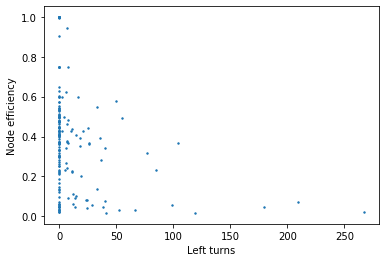

In [75]:
plt.scatter(node_stats.loc[node_stats['left_turn']<300, 'left_turn'], node_stats.loc[node_stats['left_turn']<300, 'efficiency_per_move'], s=2)
plt.xlabel('Left turns')
plt.ylabel('Node efficiency')
plt.show()

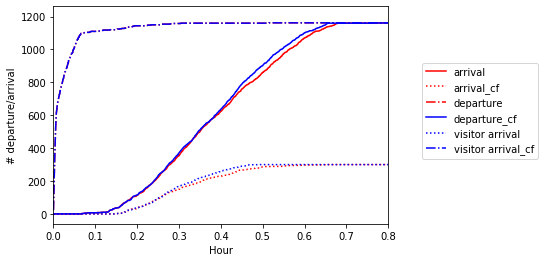

In [71]:
t_stats_1 = pd.read_csv('t_stats/t_stats_scenrs{}_f{}_c{}_vphh{}_vist{}_efficiency.csv'.format(0, 3, 0, 2, 300))
t_stats_2 = pd.read_csv('t_stats/t_stats_scenrs{}_f{}_c{}_vphh{}_vist{}_efficiency_cfb.csv'.format(0, 3, 0, 2, 300))
plt.plot(t_stats_1['t']/3600, t_stats_1['arr'], c='red', ls='-', label='arrival')
plt.plot(t_stats_1['t']/3600, t_stats_1['arr_visitor'], c='red', ls=':', label='arrival_cf')
plt.plot(t_stats_1['t']/3600, 1490-t_stats_1['predepart'], c='red', ls='-.', label='departure')
plt.plot(t_stats_2['t']/3600, t_stats_2['arr'], c='blue', ls='-', label='departure_cf')
plt.plot(t_stats_2['t']/3600, t_stats_2['arr_visitor'], c='blue', ls=':', label='visitor arrival')
plt.plot(t_stats_2['t']/3600, 1490-t_stats_2['predepart'], c='blue', ls='-.', label='visitor arrival_cf')
plt.ylabel('# departure/arrival')
plt.xlabel('Hour')
plt.xlim([0,0.8])
plt.legend(loc=(1.1, 0.3))